Thanks to :

    https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
    https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
    https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-training
    https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-inference
    https://keras.io/examples/vision/3D_image_classification/
    

In [42]:
import os 
import glob
import re
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC

In [43]:
# try:
#     # Disable all GPUS
#     tf.config.set_visible_devices([], 'GPU')
#     visible_devices = tf.config.get_visible_devices()
#     for device in visible_devices:
#         assert device.device_type != 'GPU'
# except:
#     # Invalid device or cannot modify virtual devices once initialized.
#     pass


# # tf.test.gpu_device_name()


In [44]:
## Enable this to run on PC

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], enable=True)

Num GPUs Available:  1


# Loading Data

In [45]:
# data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
# pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"

data_directory = ''
mri_types_orig = ['FLAIR','T1w','T1wCE','T2w']
mri_types = ['FLAIR']

IMAGE_SIZE = 128
NUM_IMAGES_PER_TYPE = 64
NUM_IMAGES = NUM_IMAGES_PER_TYPE * len(mri_types)
BATCH_SIZE= 4

train_df = pd.read_csv("train_labels.csv")

to_exclude = [109, 123, 709]
train_df = train_df[~train_df['BraTS21ID'].isin(to_exclude)]

train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
print(len(train_df))
train_df

582


,BraTS21ID,MGMT_value,BraTS21ID5
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
...,...,...,...
580,1005,1,01005
581,1007,1,01007
582,1008,1,01008
583,1009,0,01009


In [46]:
sample_submission = pd.read_csv('sample_submission.csv')
test=sample_submission
test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

,BraTS21ID,MGMT_value,BraTS21ID5
0,1,0.5,00001
1,13,0.5,00013
2,15,0.5,00015


# Functions to load images


In [47]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, split = 'train', mri_type="FLAIR", num_imgs=NUM_IMAGES_PER_TYPE, img_size=IMAGE_SIZE, rotate=0):

    files = sorted(glob.glob(f"{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2:2]]).T 
    if img3d.shape[-1] < num_imgs//2:
        middle = len(files)//2
        num_imgs2 = num_imgs//2
        p1 = max(0, middle - num_imgs2)
        p2 = min(len(files), middle + num_imgs2)
        img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 

    if img3d.shape[-1] < num_imgs:
        # n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        n_zero_front = np.zeros((img_size, img_size, (num_imgs - img3d.shape[-1])//2))
        n_zero_back = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1] - n_zero_front.shape[-1]))

        # img3d = np.concatenate((img3d, n_zero), axis = -1)
        img3d = np.concatenate((n_zero_front, img3d, n_zero_back), axis = -1)

        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

def load_dicom_images_3d_all(scan_id, split = 'train'):
    img3d_all = np.concatenate([load_dicom_images_3d(scan_id, split, mri_type) for mri_type in mri_types], axis = -1)
    
    return img3d_all

a = load_dicom_images_3d_all("00001", 'test')
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 128, 128, 64)
0.0 1.0 0.051694650322091466 0.00015203352961531792


# Splitting Data

In [48]:
df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=12, 
    stratify=train_df["MGMT_value"],
    shuffle=True,
)

In [49]:
del train_df
df_train

,BraTS21ID,MGMT_value,BraTS21ID5
278,405,0,00405
446,645,0,00645
511,746,1,00746
46,71,1,00071
269,392,0,00392
...,...,...,...
106,158,0,00158
199,294,1,00294
116,172,0,00172
468,682,0,00682


#  Custom Data Generator

In [50]:
from tensorflow.keras.utils import Sequence

class Dataset(Sequence):
    def __init__(self,df,split = 'train', is_train=True,batch_size=BATCH_SIZE,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.split = split
        
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        split=self.split
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        if split == 'train':
            list_x =  [load_dicom_images_3d_all(x, split) for x in batch_paths]
            batch_X = np.stack(list_x, axis=4)
        else:
            list_x =  load_dicom_images_3d_all(id_path, split)
            batch_X = np.stack(list_x)
            
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X


In [51]:
train_dataset = Dataset(df_train, 'train')
valid_dataset = Dataset(df_valid, 'train')
test_dataset = Dataset(test, 'test', is_train=False)

# print(len(train_dataset))
# print([type(a) for a in train_dataset[0]])
# print([a.shape for a in train_dataset[0]])
# print(train_dataset[0][0][0][0][0][0])
# print(len(test_dataset))

In [52]:
def plot_sample_all(images, label, j): 
    plt.figure(figsize=(35, 35))
    for i in range(NUM_IMAGES):
        # plt.subplot(14,14,(i+1))
        plt.subplot(16,16,(i+1))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[0,:,:,i,j], cmap="gray")
    plt.show()

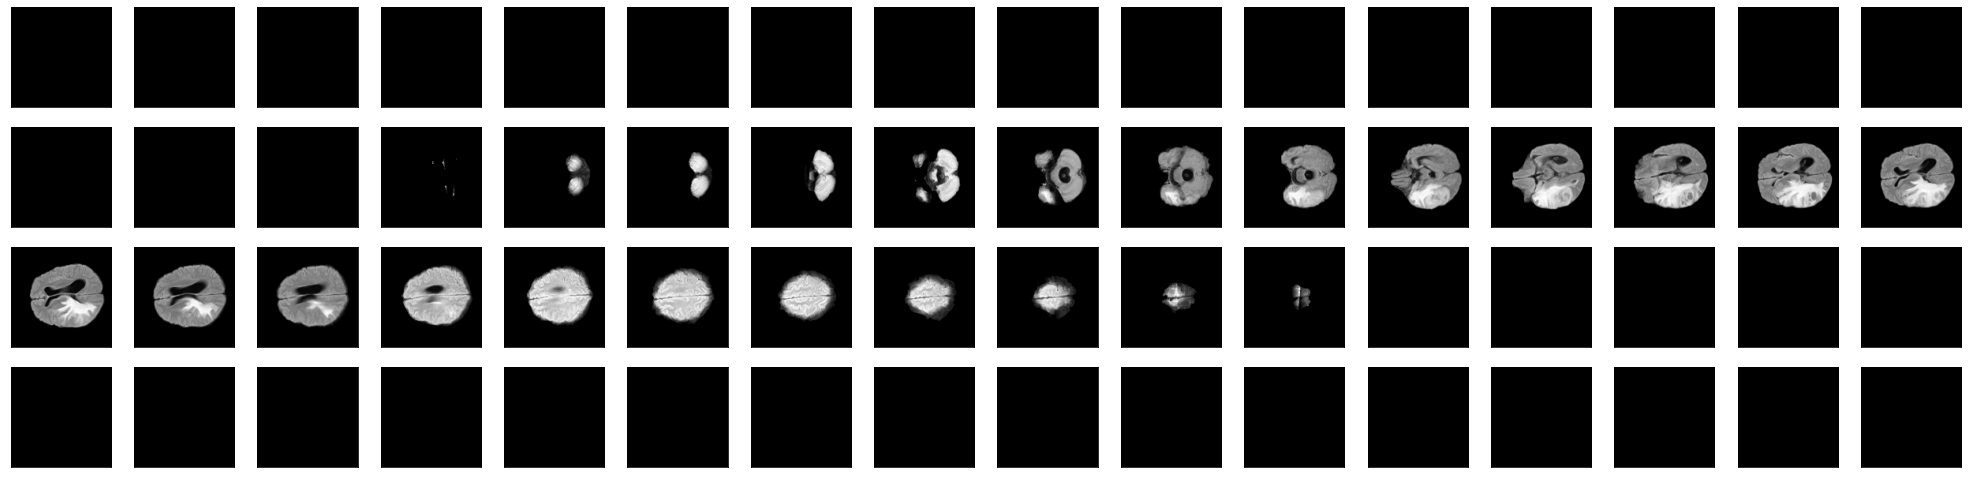

In [53]:
i = 0
j = 0
images, label = train_dataset[i]
plot_sample_all(images, label, j)

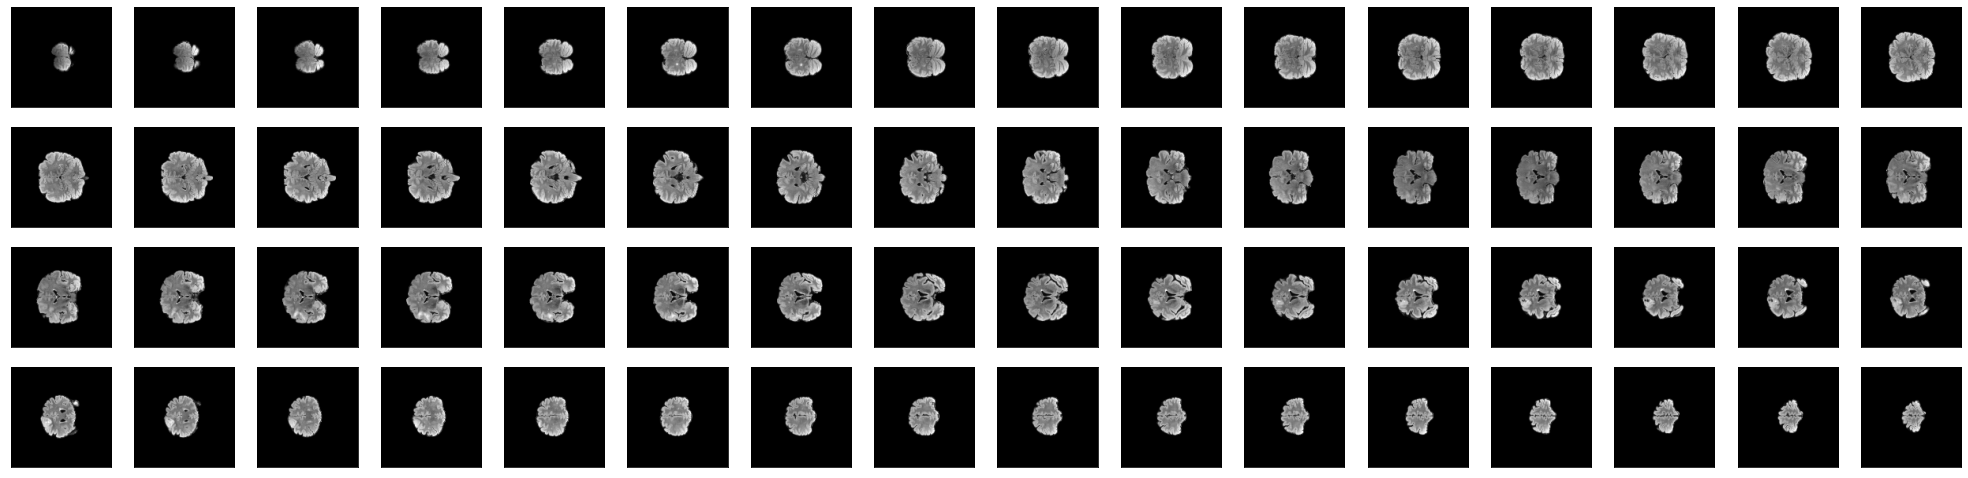

In [54]:
i = 0
j = 1
images, label = train_dataset[i]
plot_sample_all(images, label, j)

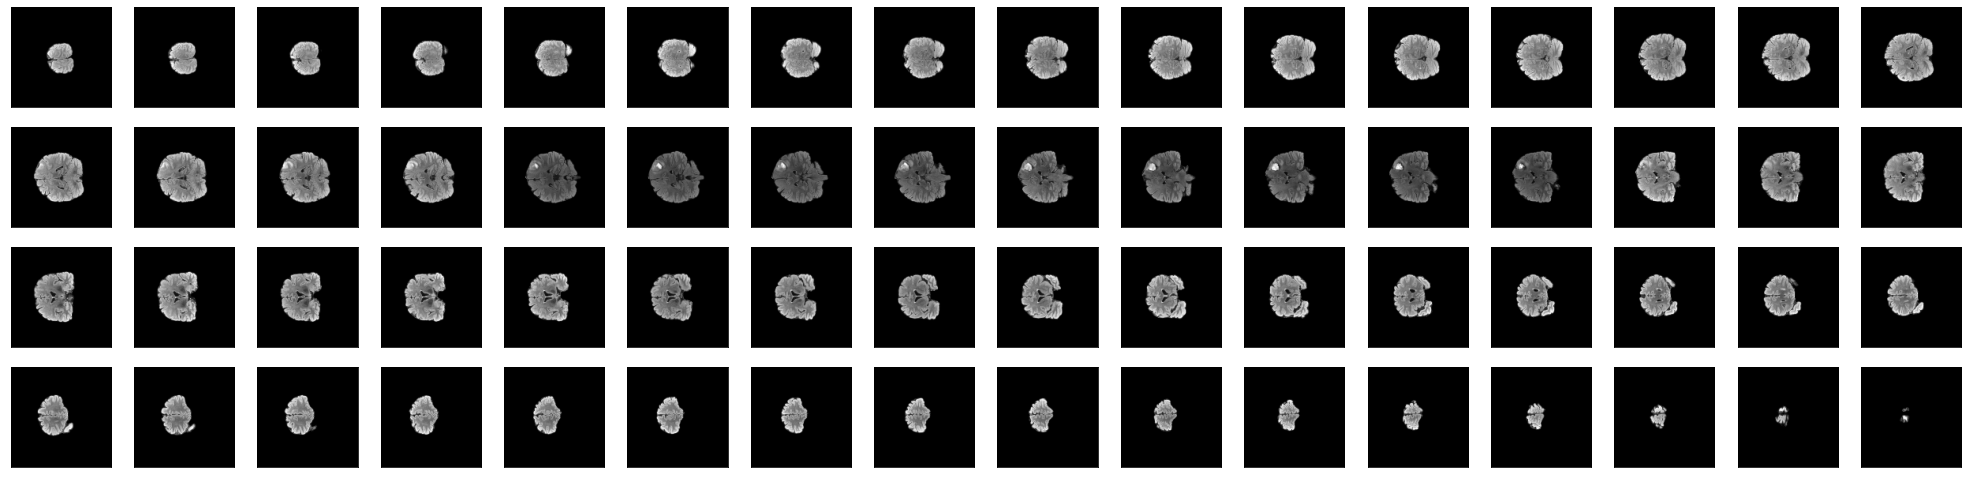

In [55]:
i = 0
j = 2
images, label = train_dataset[i]
plot_sample_all(images, label, j)

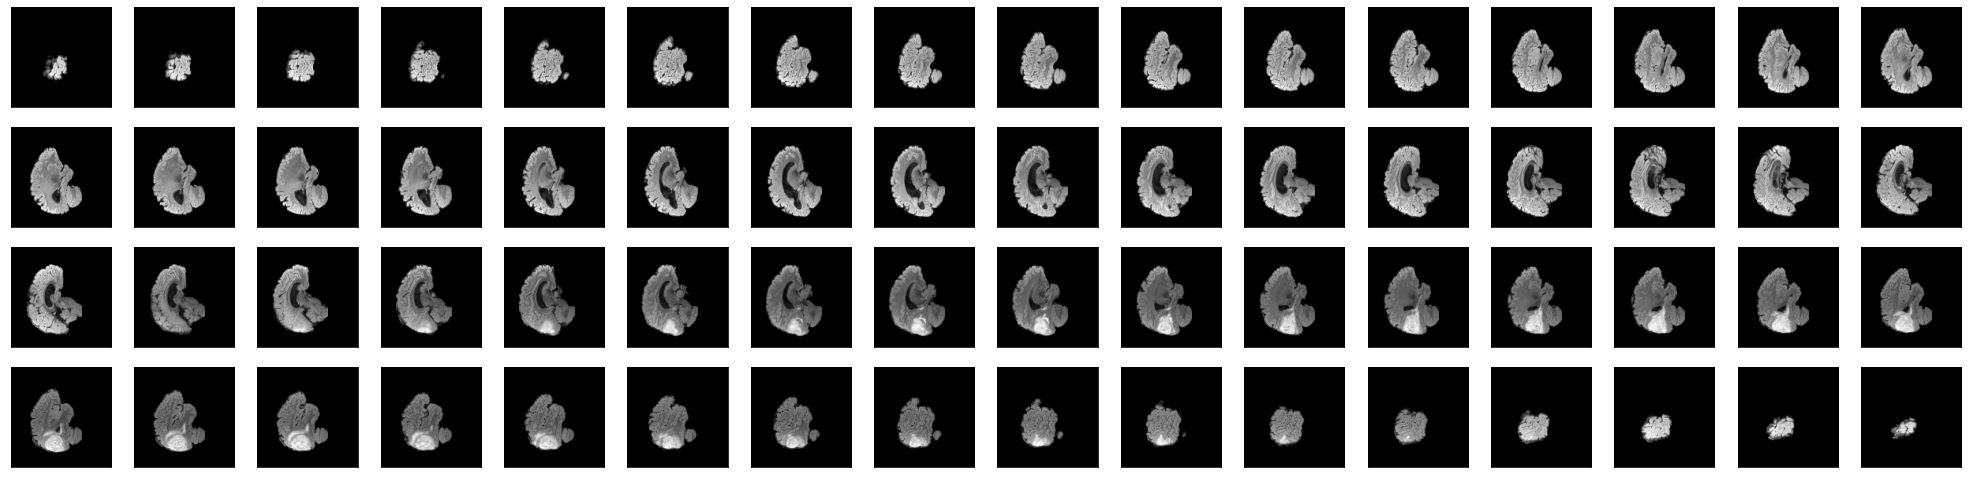

In [56]:
i = 0
j = 3
images, label = train_dataset[i]
plot_sample_all(images, label, j)

In [57]:
def plot_sample_train(images, label): 
    plt.figure(figsize=(16, 16))
    idx_base = int(NUM_IMAGES_PER_TYPE/2)
    # idx = [idx_base, idx_base*3, idx_base*5, idx_base*7]
    # idx = [idx_base, idx_base*3, idx_base*5]
    idx = [idx_base]
    for i in range(len(idx)*BATCH_SIZE):
        plt.subplot(BATCH_SIZE,len(idx),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        j = int(i/len(idx))
        plt.imshow(images[0,:,:,idx[i%len(idx)],j], cmap="gray")
        plt.xlabel(f'{idx[i%len(idx)]} {label[j]}')
    plt.show()

Dimension of the CT scan is: (1, 128, 128, 64, 4)
label= [0 0 1 1] (4,)


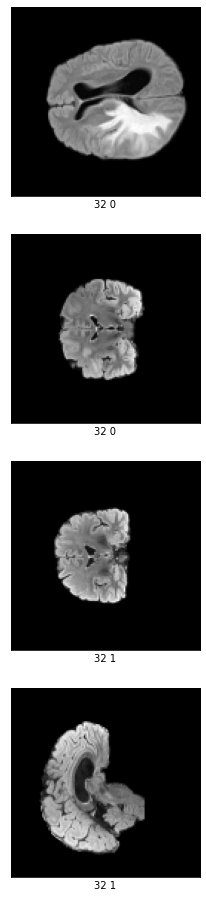

In [58]:
i = 0
images, label = train_dataset[i]
print("Dimension of the CT scan is:", images.shape)
print("label=",label ,label.shape)
plot_sample_train(images, label)

In [59]:
def plot_sample_test(images): 
    plt.figure(figsize=(16, 16))
    idx_base = int(NUM_IMAGES_PER_TYPE/2)
    # idx = [idx_base, idx_base*3, idx_base*5, idx_base*7]
    # idx = [idx_base, idx_base*3, idx_base*5]
    idx = [idx_base]

    for i in range(len(idx)*BATCH_SIZE):
        plt.subplot(BATCH_SIZE,len(idx),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        j = int(i/len(idx))
        plt.imshow(images[0,:,:,idx[i%len(idx)],j], cmap="gray")
        plt.xlabel(idx[i%len(idx)])
    plt.show()

Dimension of the CT scan is: (1, 128, 128, 64, 4)


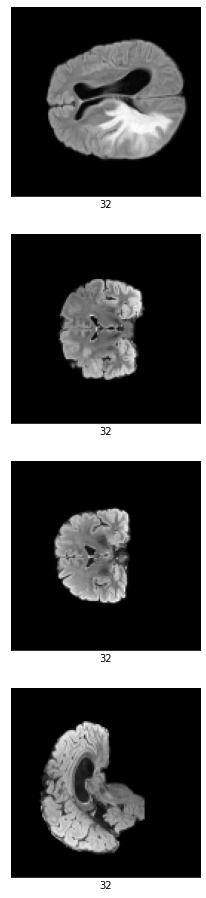

In [60]:
i = 0
image = test_dataset[i]
# print(test_dataset[0])
print("Dimension of the CT scan is:", images.shape)
plot_sample_test(images)

# Model

In [61]:
def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=NUM_IMAGES):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.01)(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.01)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.02)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.03)(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.04)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.08)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3D_CNN")

    return model

In [62]:
# Build model.
model = get_model()
model.summary()

Model: "3D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 31, 64)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 61, 61, 29, 128)   221312    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 30, 30, 14, 128)   0    

# Training

In [63]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

# # Compile model.
# initial_learning_rate = 0.0001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
# )
# model.compile(
#     loss="binary_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
# #     metrics=["acc"],
#     metrics=[AUC(name='auc'),"acc"],
# )
# # Define callbacks.
# checkpoint_cb = ModelCheckpoint('Brain_3d_combined.h5', 
#                                 save_best_only = True)
# early_stopping_cb = EarlyStopping(monitor = 'val_acc', 
#                                   patience = 15,
#                                   restore_best_weights = True)

# # checkpoint_cb = ModelCheckpoint('Brain_3d_FLAIR.h5', 
# #                              save_best_only = True, 
# #                              monitor = 'val_auc', 
# #                              mode = 'max', verbose = 1)
# # early_stopping_cb = EarlyStopping(monitor = 'val_auc', 
# #                            patience = 15, mode = 'max', verbose = 1,
# #                            restore_best_weights = True)

# # Train the model, doing validation at the end of each epoch
# epochs = 100

# history = model.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=epochs,
#     shuffle=True,
#     verbose=1,
#     callbacks = [checkpoint_cb, early_stopping_cb],
# )

In [64]:
print(tf.__version__)
train_dataset[0][0].shape

2.4.0


(1, 128, 128, 64, 4)

In [65]:
from tensorflow.keras.optimizers import schedules, Adam

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=[AUC(name='auc'),"acc"],
    # metrics=["acc"],
)
# Define callbacks.
model_save = ModelCheckpoint('Brain_Tumor_All_MRI_3D_CNN.h5', 
                             save_best_only = True, 
                             monitor = 'val_acc', 
                             mode = 'max', verbose = 1)

early_stop = EarlyStopping(monitor = 'val_acc', 
                           patience = 15, mode = 'max', verbose = 1,
                           restore_best_weights = True)

# Train the model, doing validation at the end of each epoch
epochs = 100


model.fit(
    train_dataset,
    validation_data= valid_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks = [model_save, early_stop],
)

Epoch 1/100
117/117 [==============================] - 144s 1s/step - loss: 0.6933 - auc: 0.4456 - acc: 0.5185 - val_loss: 0.6991 - val_auc: 0.5897 - val_acc: 0.5299

Epoch 00001: val_acc improved from -inf to 0.52991, saving model to Brain_Tumor_All_MRI_3D_CNN.h5
Epoch 2/100
117/117 [==============================] - 154s 1s/step - loss: 0.6924 - auc: 0.4849 - acc: 0.5294 - val_loss: 0.7594 - val_auc: 0.5573 - val_acc: 0.5299

Epoch 00002: val_acc did not improve from 0.52991
Epoch 3/100
117/117 [==============================] - 139s 1s/step - loss: 0.6923 - auc: 0.5111 - acc: 0.5266 - val_loss: 0.7938 - val_auc: 0.5629 - val_acc: 0.5299

Epoch 00003: val_acc did not improve from 0.52991
Epoch 4/100
117/117 [==============================] - 140s 1s/step - loss: 0.6938 - auc: 0.4533 - acc: 0.5132 - val_loss: 0.9186 - val_auc: 0.5626 - val_acc: 0.5299

Epoch 00004: val_acc did not improve from 0.52991
Epoch 5/100
117/117 [==============================] - 144s 1s/step - loss: 0.6923 -

KeyboardInterrupt: 

# Visualizing model performance

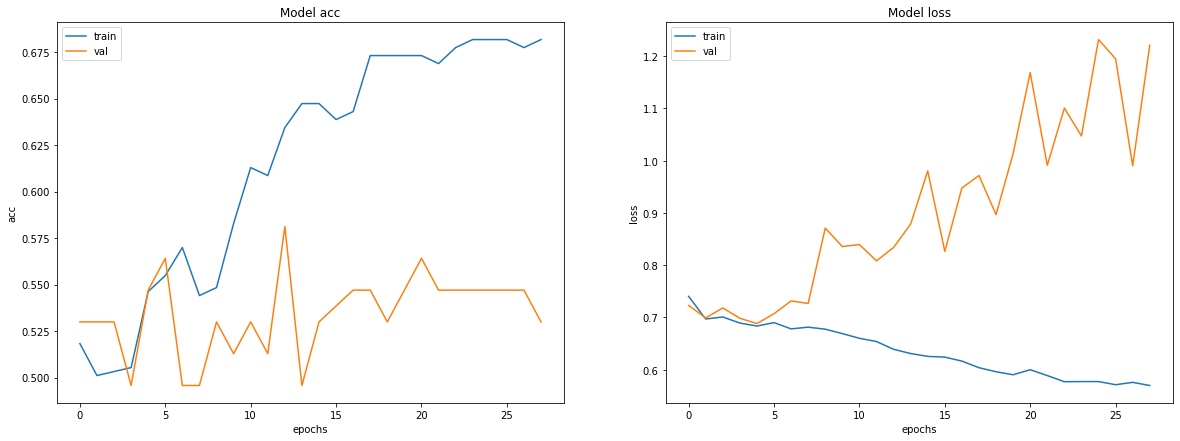

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
del train_dataset
del valid_dataset

In [ ]:
model.load_weights('./Brain_Tumor_All_MRI_3D_CNN.h5')

In [ ]:
from tensorflow.keras.utils import Sequence

class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=1,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x =  load_dicom_images_3d_all(id_path, 'test') #str(scan_id).zfill(5)
        #list_x =  [load_dicom_images_3d(x) for x in batch_paths]
        batch_X = np.stack(list_x)
        if self.is_train:
            return batch_X,batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

In [ ]:
test_dataset = Dataset(df=test, is_train=False)

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds = preds.reshape(-1)

In [ ]:
submission = pd.DataFrame({'BraTS21ID':sample_submission['BraTS21ID'],'MGMT_value':preds})

In [ ]:
submission

,BraTS21ID,MGMT_value
0,1,0.798947
1,13,0.776614
2,15,0.642861
3,27,0.806810
4,37,0.740492
...,...,...
82,826,0.598981
83,829,0.687272
84,833,0.597561
85,997,0.526871


In [ ]:
submission['BraTS21ID'] = [format(x, '05d') for x in submission.BraTS21ID]

In [ ]:
submission

,BraTS21ID,MGMT_value
0,00001,0.798947
1,00013,0.776614
2,00015,0.642861
3,00027,0.806810
4,00037,0.740492
...,...,...
82,00826,0.598981
83,00829,0.687272
84,00833,0.597561
85,00997,0.526871


In [ ]:
submission.to_csv('submission.csv',index=False)